In [401]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as ptch

from datetime import datetime
import time
from os import listdir
from os.path import isfile, join
import re

plt.rcParams.update(plt.rcParamsDefault)

In [402]:
!pip freeze > requirements.txt

You are using pip version 10.0.1, however version 20.2b1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


# Non-Pharmaceutical Interventions in Canada

Here we show comparisons of descriptive statistics for each regional and subregional-level dataset across Canada. Download individual region CSVs from the Google Sheet and place them in `./data/`. 

Stats Canada data on population size by province available from: 

Statistics Canada. Table 17-10-0009-01 Population estimates, quarterly"
https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=1710000901
DOI: https://doi.org/10.25318/1710000901-eng


In [403]:
cutoff_date = datetime(2020, 5, 3)

In [404]:
stats_columns=[
    'file',
    'region',
    'subregion', 
    'rows',
    'columns',
    'start_date.min', 
    'start_date.max', 
    'end_date.min', 
    'end_date.max', 
    'end_date.count / count', 
    'reviewer.unique', 
    'intervention_summary.unique', 
    'intervention_category.unique',
    'target_population_category.unique',
    'target_population_category (% not "General")',
    'enforcement_category.unique',
    'oxford_government_response_category.notna',
    'oxford_government_response_category.unique',
    'oxford_fiscal_measure_cad.sum',
    'source_url.unique'
]

columns=[
    'start_date',
    'end_date',
    'reviewer',
    'country',
    'region',
    'subregion',
    'intervention_summary',
    'intervention_category',
    'target_population_category',
    'enforcement_category',
    'oxford_government_response_category',
    'oxford_closure_code',
    'oxford_public_info_code',
    'oxford_travel_code',
    'oxford_geographic_target_code',
    'oxford_fiscal_measure_cad',
    'oxford_monetary_measure',
    'oxford_testing_code',
    'oxford_tracing_code',
    'oxford_restriction_code',
    'oxford_income_amount',
    'oxford_income_target',
    'oxford_debt_relief_code',
    'source_url',
    'source_organization',
    'source_organization_2',
    'source_category',
    'source_title',
    'source_full_text',
    'note',
    'end_source_url',
    'end_source_organization',
    'end_source_organization_2',
    'end_source_category',
    'end_source_title',
    'end_source_full_text'
]

In [405]:
population_df = pd.read_csv('data/statscan-population-q.csv', thousands=',')
population_df[['Geography', 'Q1 2020']]
population_df['region'] = population_df['Geography']
population_df['population_q1_2020'] = pd.to_numeric(population_df['Q1 2020'])
population_df = population_df[['region', 'population_q1_2020']]
population_df

,region,population_q1_2020
0,Canada,37894799
1,Newfoundland and Labrador,521365
2,Prince Edward Island,158158
3,Nova Scotia,977457
4,New Brunswick,779993
5,Quebec,8537674
6,Ontario,14711827
7,Manitoba,1377517
8,Saskatchewan,1181666
9,Alberta,4413146


In [406]:
full_df = pd.read_csv('SCHEMA UPDATE - Collecting NPIs Effects - FULL.csv', error_bad_lines=False)
full_df['start_date'] = pd.to_datetime(full_df['start_date'], format='%m/%d/%Y', errors='coerce')
full_df['end_date'] = pd.to_datetime(full_df['end_date'], format='%m/%d/%Y', errors='coerce')
full_df['oxford_fiscal_measure_cad'] = full_df['oxford_fiscal_measure_cad'].replace('[\$,]', '', regex=True).astype(float)



In [407]:
full_df = full_df[full_df['start_date'] <= cutoff_date]
full_df = full_df[~full_df['start_date'].isna()]

provinces_df = full_df[full_df['subregion'].isna() & full_df['region'].notna() & (full_df['region'] != "All")]

federal_df = full_df[full_df['subregion'].isna() & (full_df['region'].isna() | (full_df['region'] == "All"))]

In [408]:
full_df.shape

(2920, 35)

In [409]:
provinces_df.shape

(1501, 35)

In [410]:
federal_df.shape

(80, 35)

In [411]:
full_df.drop(columns=['reviewer']).to_csv('npi_canada.csv')
provinces_df.drop(columns=['reviewer']).to_csv('npi_by_province.csv')
federal_df.drop(columns=['reviewer']).to_csv('npi_federal.csv')

# Descriptive Statistics for Paper

In [412]:
print("Number of interventions recorded: ", full_df.shape[0])

Number of interventions recorded:  2920


In [413]:
print("Number of oxford interventions recorded: ", full_df['oxford_government_response_category'].count())

Number of oxford interventions recorded:  1430


In [414]:
#n = full_df[full_df['oxford_government_response_category'].isin(['S8 Fiscal measures', 'S9 Monetary measures (interest rate)', 'S10 Emergency investment in health care', 'S11 Investment in vaccines', 'S12 Testing policy', 'S13 Contact tracing'])]['oxford_government_response_category'].count()
#print("Number of oxford interventions in Stringency Index recorded (S1-S7): ", n)

In [415]:
#n / full_df.shape[0]

In [416]:
print("Number of unique source urls: ", len(full_df['source_url'].unique()))

Number of unique source urls:  1704


In [417]:
print("Number of unique primary source organizations: ", len(full_df['source_organization'].unique()))

Number of unique primary source organizations:  253


In [418]:
oxford_ratio = full_df['oxford_government_response_category'].count() / full_df['intervention_category'].count()
print("% of interventions with oxford classifications: ", oxford_ratio)



% of interventions with oxford classifications:  0.49361408353469105


In [419]:
full_df['oxford_government_response_category'].value_counts().sort_index()

C1 School Closing                           54 
C2 Workplace Closures                       235
C3 Cancel public events                     166
C4 Public Gathering Restrictions            4  
C5 Close public transport                   7  
C7 Restrictions on internal movements       173
C8 International Travel Controls            56 
E1 Income Support                           4  
E2 Debt / Contract Relief for Households    7  
E3 Fiscal measures                          261
E4 Support for Other Countries              1  
H1 Public Info Campaigns                    329
H2 Testing policy                           45 
H3 Contact tracing                          6  
H4 Emergency investment in health care      74 
H5 Investment in vaccines                   8  
Name: oxford_government_response_category, dtype: int64

In [420]:
#assert full_df['oxford_government_response_category'].nunique() == 17

In [421]:
print("Number of regions: ", full_df['region'].nunique())
print("Number of subregions: ", full_df['subregion'].nunique())

assert full_df['region'].nunique() == 15 # 13 provinces + nan + All
assert full_df['subregion'].nunique() == 21

Number of regions:  15
Number of subregions:  21


# NPIs before Key Dates

In [422]:
full_11_df = full_df[full_df['start_date'] < '2020-03-11']
print("Number of interventions recorded before may 11: ", full_11_df.shape[0])
print("Number of interventions recorded before may 11 (%): ", full_11_df.shape[0] / full_df.shape[0])


Number of interventions recorded before may 11:  137
Number of interventions recorded before may 11 (%):  0.046917808219178084


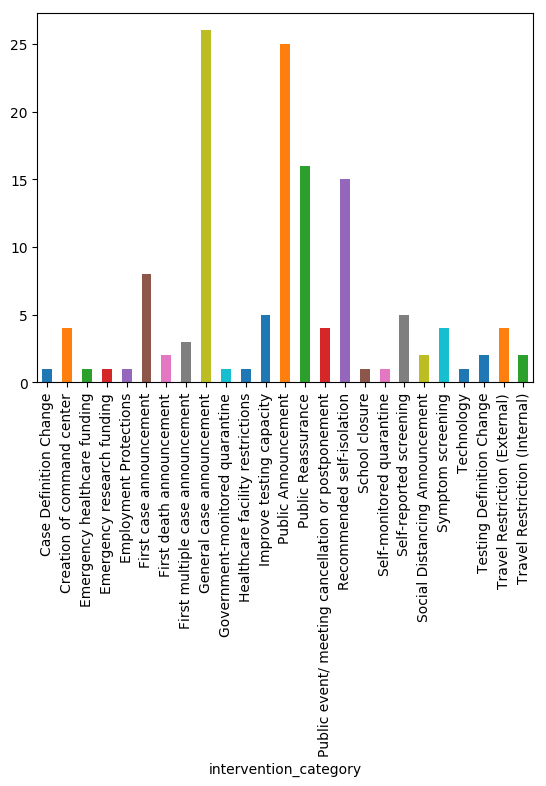

In [423]:
full_11_df.groupby(by='intervention_category')['start_date'].count().plot.bar()

In [424]:
full_1_df = full_df[full_df['start_date'] < '2020-01-25'] # first case
print("Number of interventions recorded before Jan 25: ", full_1_df.shape[0])
print("Number of interventions recorded before Jan 25 (%): ", full_1_df.shape[0] / full_df.shape[0])


Number of interventions recorded before Jan 25:  9
Number of interventions recorded before Jan 25 (%):  0.0030821917808219177


In [425]:
9 / full_df.shape[0]

0.0030821917808219177

In [426]:
full_1_df['intervention_category'].unique()

array(['Public Announcement', 'Public Reassurance',
       'Self-reported screening', 'Symptom screening',
       'Improve testing capacity'], dtype=object)

## NPI: Enforcement Categories


In [427]:
len(full_df['enforcement_category'].unique())

6

In [428]:
full_df.groupby(by='enforcement_category').count().max(axis=1).sort_values()

enforcement_category
Arrest              7   
Legal Action        41  
Fines               92  
Refusal of Entry    172 
Not Applicable      2529
dtype: int64

Text(0.5,0,'count')

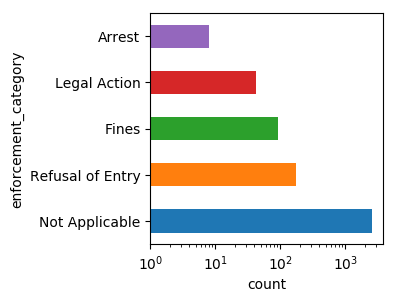

In [429]:
full_df.groupby(by="enforcement_category").count().max(axis=1).sort_values(ascending=False).plot.barh(log=True, figsize=(3,3))
plt.xlabel('count')

## Target Population Categories

In [430]:
len(full_df['target_population_category'].unique())

18

Text(0.5,0,'count')

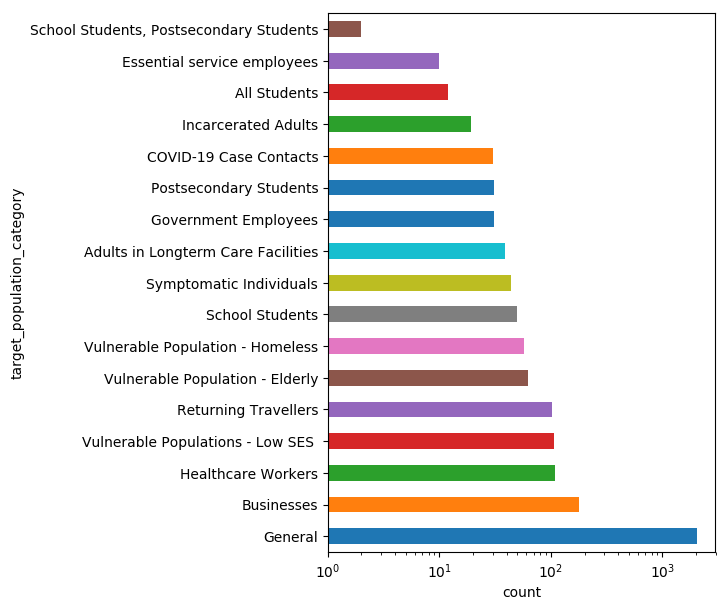

In [431]:
full_df.groupby(by="target_population_category").count().max(axis=1).sort_values(ascending=False).plot.barh(log=True, figsize=(5,7))
plt.xlabel('count')

## NPI: Intervention Categories

In [432]:
len(full_df['intervention_category'].unique())

62

Lets show examples of the top 15 interventions by count

In [433]:
intervention_counts = pd.DataFrame(full_df.groupby(by='intervention_category').count().max(axis=1))

In [434]:
pd.set_option('display.max_colwidth', -1)

examples = pd.DataFrame(full_df.groupby(by='intervention_category').apply(lambda x: x.sample(1, random_state=3)['intervention_summary'].values[0]))

intervention_counts.merge(examples, left_index=True, right_index=True).sort_values(by='0_x', ascending=False)[0:17]



,0_x,0_y
intervention_category,,
Public Announcement,400,Manitoba joins Federal Day of Mourning in honour of workers who suffered from workplace injury or illness
General case announcement,286,Updated announcement of cases and deaths
Emergency economic funding,192,City permits grace period for interim property tax payments
Social Distancing Announcement,156,Suspension of supervised visit between the child / (grand) parents
Emergency social services funding,145,Financial support from Telus in the form of grants to local grassroots charities
Public event/ meeting cancellation or postponement,97,"All March Break programming, camps and drop-in activities are cancelled"
Administrative flexibility,93,Sale of outdoor licenses and permits has been launched online.
Recreational / Entertainment Facility Closure,92,Closure of Museums
Healthcare facility restrictions,77,"Banned certain individuals from visiting hospitals (Individuals who have travelled outside of Yukon in the last 14 days, or who are feeling sick)."


In [435]:
full_df[full_df['oxford_government_response_category'].isna()].groupby(by='intervention_category').count().max(axis=1).sort_values(ascending=False)


intervention_category
Public Announcement                                   271
General case announcement                             221
Administrative flexibility                            70 
Social Distancing Announcement                        66 
Healthcare facility restrictions                      57 
Emergency social services funding                     56 
Declaration of emergency (or similar)                 54 
Public Reassurance                                    44 
Health workforce task-shifting                        40 
Recreational / Entertainment Facility Closure         35 
Public park closure                                   34 
Emergency economic funding                            32 
Improve testing capacity                              32 
Recommended self-isolation                            31 
Employment Protections                                28 
Increased sanitation measures                         28 
Social Service provider restrictions              

Text(0.5,0,'count')

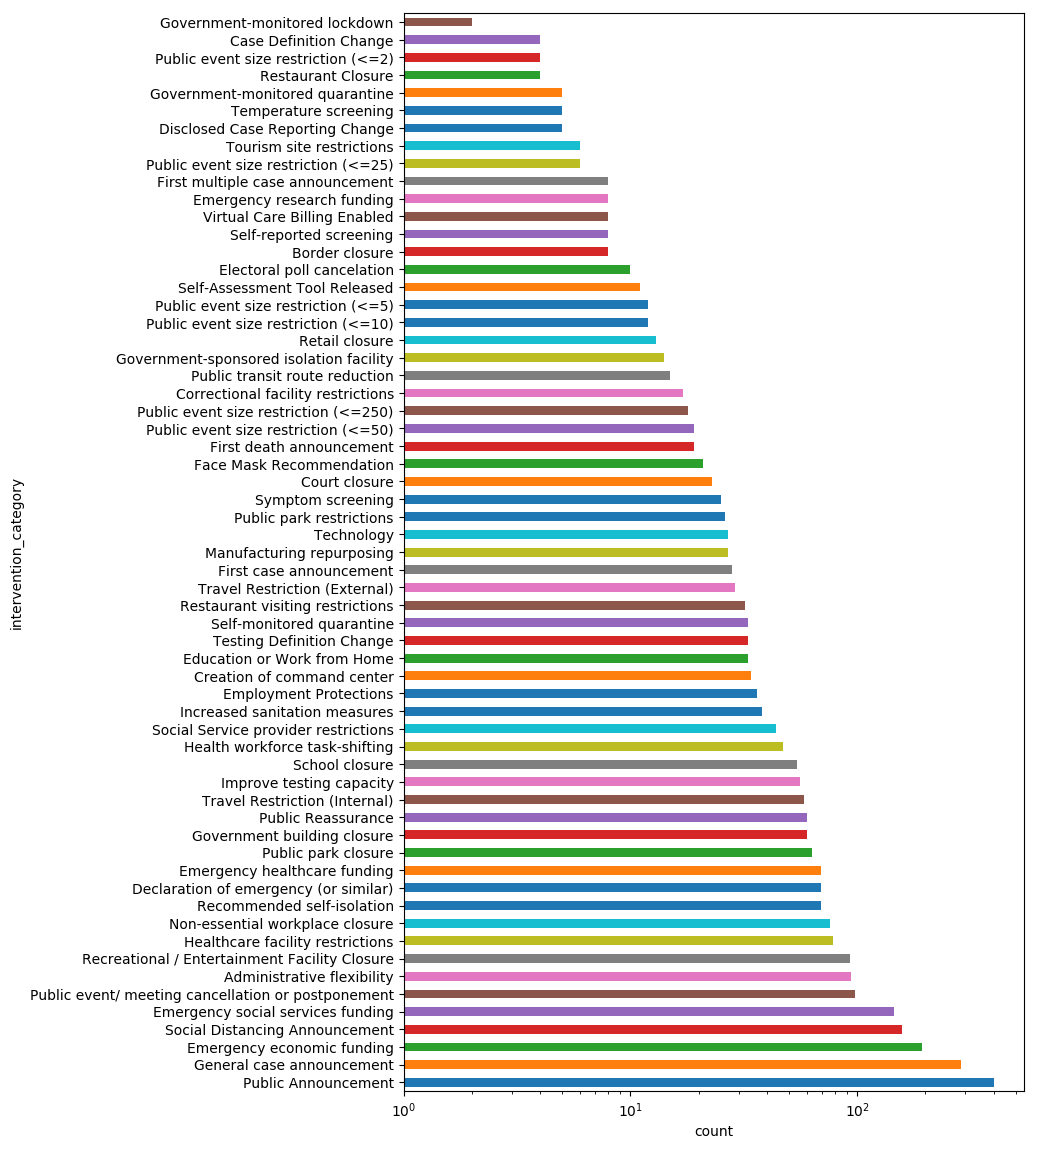

In [436]:

full_df.groupby(by="intervention_category").count().max(axis=1).sort_values(ascending=False).plot.barh(log=True, figsize=(8,14))
plt.xlabel('count')


# Sources

Looking at unique source urls, organizations, and source types

In [437]:
a = full_df['source_organization'].unique()
a.shape

(253,)

In [438]:
b = full_df['source_organization_2'].unique()

In [439]:
all_sources = list(set(a) | set(b))
len(all_sources)

353

## NPI: Fiscal Measures

Show investments by province or subregion

In [440]:
#fig, ax = plt.subplots(figsize=(12,10))

dates = pd.date_range(start='03-01-2020', end='05-20-2020', name='dates').to_series() #mm-dd-yyyy
gb = provinces_df[provinces_df['oxford_fiscal_measure_cad'].notna()][['start_date', 'region', 'oxford_fiscal_measure_cad']].groupby(by='region')
provinces_fiscal = pd.DataFrame(dates)

for g_name, g_df in gb:
    all_dates_df = g_df.join(dates, on='start_date', how='right')
    all_dates_df['oxford_fiscal_measure_cad'] = all_dates_df['oxford_fiscal_measure_cad'].fillna(0)
    all_dates_df = all_dates_df.sort_values(by='start_date', ascending=True)
    all_dates_df['cumulative'] = all_dates_df['oxford_fiscal_measure_cad'].cumsum(axis=0)
    all_dates_df.set_index('start_date')
    all_dates_df = all_dates_df.groupby(by='start_date').sum()

    provinces_fiscal[g_name] = all_dates_df['cumulative']

#plt.yscale('log')
#plt.title('')
#plt.ylabel('Fiscal Interventions ($)')
#plt.xlabel('Date')

#provinces_fiscal

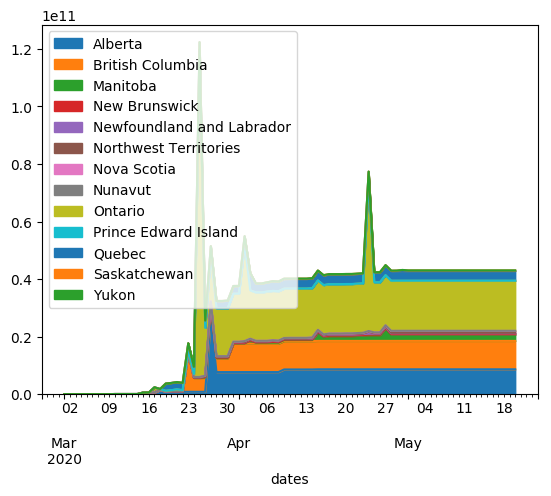

In [441]:
print("WARNING: Not Correct Yet")
provinces_fiscal.drop(['dates'], axis=1).plot.area()

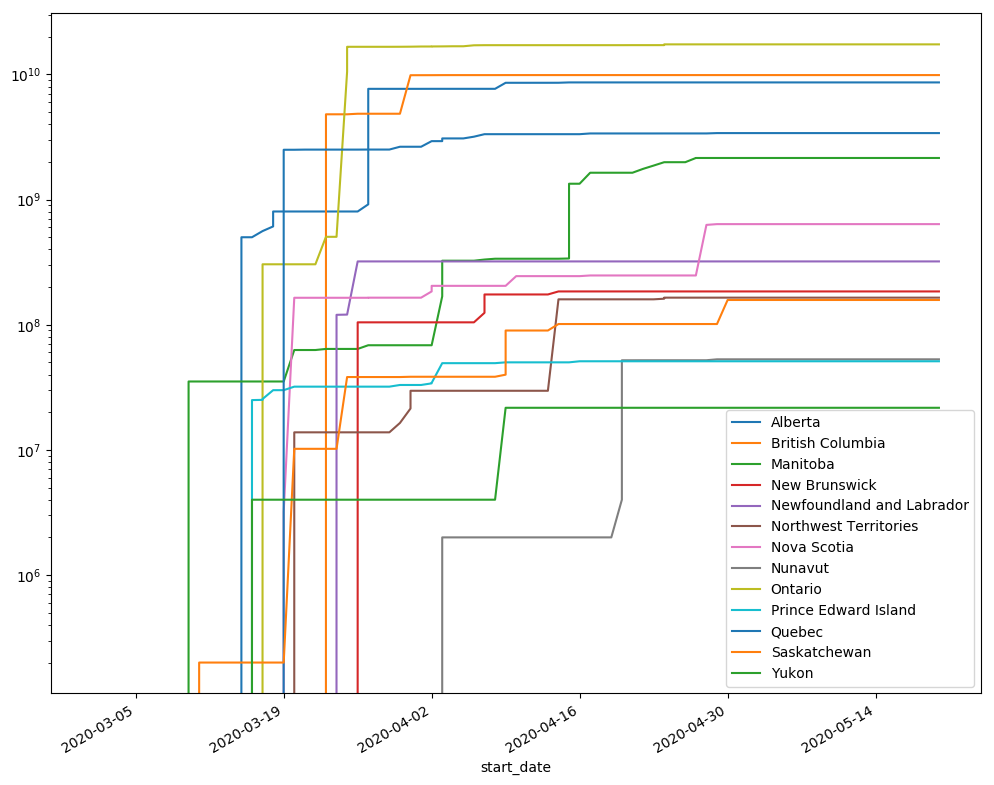

In [442]:
fig, ax = plt.subplots(figsize=(12,10))

dates = pd.date_range(start='03-01-2020', end='05-20-2020', name='dates').to_series() #mm-dd-yyyy
gb = provinces_df[provinces_df['oxford_fiscal_measure_cad'].notna()][['start_date', 'region', 'oxford_fiscal_measure_cad']].groupby(by='region')

for g_name, g_df in gb:
    all_dates_df = g_df.join(dates, on='start_date', how='right')
    all_dates_df['oxford_fiscal_measure_cad'] = all_dates_df['oxford_fiscal_measure_cad'].fillna(0)
    all_dates_df = all_dates_df.sort_values(by='start_date', ascending=True)
    all_dates_df['oxford_fiscal_measure_cad_cumsum'] = all_dates_df['oxford_fiscal_measure_cad'].cumsum(axis=0)
    #print(all_dates_df)
    all_dates_df.plot(x='start_date', y='oxford_fiscal_measure_cad_cumsum', label=g_name, ax=ax)

plt.yscale('log')

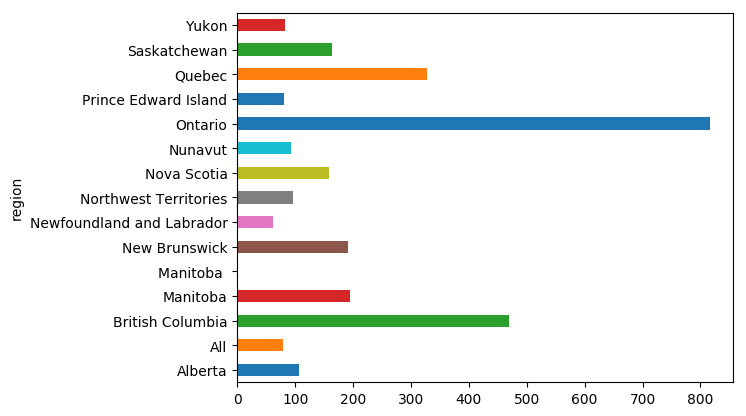

In [443]:
full_df.groupby(by=['region']).count().max(axis=1).plot.barh()

In [444]:
full_df.groupby(by=['region'])['start_date'].quantile(0.5).sort_values()

region
British Columbia            2020-03-23 00:00:00
Newfoundland and Labrador   2020-03-23 00:00:00
Saskatchewan                2020-03-23 00:00:00
Nunavut                     2020-03-24 12:00:00
Prince Edward Island        2020-03-25 00:00:00
Quebec                      2020-03-25 00:00:00
Nova Scotia                 2020-03-27 00:00:00
Ontario                     2020-03-28 00:00:00
Northwest Territories       2020-03-28 12:00:00
Alberta                     2020-03-29 12:00:00
All                         2020-03-30 00:00:00
New Brunswick               2020-04-01 00:00:00
Yukon                       2020-04-03 00:00:00
Manitoba                    2020-04-08 00:00:00
Manitoba                    2020-04-30 00:00:00
Name: start_date, dtype: datetime64[ns]

# Temporal Distribution of Events

In [445]:
full_df['start_date'].quantile(0.5)

Timestamp('2020-03-27 00:00:00')

In [446]:
provinces_df['start_date'].quantile(0.5)

Timestamp('2020-03-27 00:00:00')

In [447]:
full_df['start_date'].quantile(0.5)

Timestamp('2020-03-27 00:00:00')

In [448]:
earliest_dates = provinces_df.groupby(by='region')['start_date'].min()
earliest_dates

region
Alberta                     2020-03-05
British Columbia            2020-01-20
Manitoba                    2020-01-28
New Brunswick               2020-03-01
Newfoundland and Labrador   2020-03-06
Northwest Territories       2020-03-10
Nova Scotia                 2020-02-28
Nunavut                     2020-01-07
Ontario                     2020-01-22
Prince Edward Island        2020-02-28
Quebec                      2020-03-11
Saskatchewan                2020-02-13
Yukon                       2020-03-07
Name: start_date, dtype: datetime64[ns]

In [449]:
assert earliest_dates.min() > datetime(2020, 1, 1)

In [450]:
latest_dates = provinces_df.groupby(by='region')['start_date'].max()
latest_dates

region
Alberta                     2020-04-17
British Columbia            2020-04-20
Manitoba                    2020-05-03
New Brunswick               2020-05-03
Newfoundland and Labrador   2020-04-15
Northwest Territories       2020-04-30
Nova Scotia                 2020-05-03
Nunavut                     2020-04-30
Ontario                     2020-05-01
Prince Edward Island        2020-04-18
Quebec                      2020-04-29
Saskatchewan                2020-05-01
Yukon                       2020-05-01
Name: start_date, dtype: datetime64[ns]

In [451]:
assert latest_dates.min() <= cutoff_date

In [452]:
cma_earliest_dates = full_df.dropna(subset=['subregion']).groupby(by='subregion')['start_date'].min()
cma_earliest_dates

subregion
Calgary              2020-03-10
Edmonton             2020-03-14
Gatineau             2020-03-13
Halifax              2020-03-16
Hamilton             2020-03-11
Kelowna              2020-03-07
Kitchener-Waterloo   2020-03-05
London               2020-03-12
Montreal             2020-02-28
Niagara              2020-03-13
Oshawa               2020-03-13
Ottawa               2020-03-11
Quebec City          2020-03-13
Regina               2020-03-16
Saskatoon            2020-03-12
St. John's           2020-03-13
Toronto              2020-01-07
Vancouver            2020-03-09
Victoria             2020-03-11
Windsor              2020-02-28
Winnipeg             2020-03-12
Name: start_date, dtype: datetime64[ns]

In [453]:
assert cma_earliest_dates.min() > datetime(2020, 1, 1)

In [454]:
cma_latest_dates = full_df.dropna(subset=['subregion']).groupby(by='subregion')['start_date'].max()
cma_latest_dates

subregion
Calgary              2020-04-24
Edmonton             2020-04-20
Gatineau             2020-04-30
Halifax              2020-04-15
Hamilton             2020-05-01
Kelowna              2020-04-28
Kitchener-Waterloo   2020-04-29
London               2020-05-01
Montreal             2020-05-02
Niagara              2020-04-16
Oshawa               2020-04-29
Ottawa               2020-05-01
Quebec City          2020-04-15
Regina               2020-05-01
Saskatoon            2020-05-01
St. John's           2020-04-20
Toronto              2020-05-03
Vancouver            2020-04-23
Victoria             2020-05-01
Windsor              2020-05-03
Winnipeg             2020-05-01
Name: start_date, dtype: datetime64[ns]

In [455]:
assert cma_latest_dates.min() <= cutoff_date

DatetimeIndex(['2019-12-31', '2020-01-31', '2020-02-29', '2020-03-31'], dtype='datetime64[ns]', freq='M')


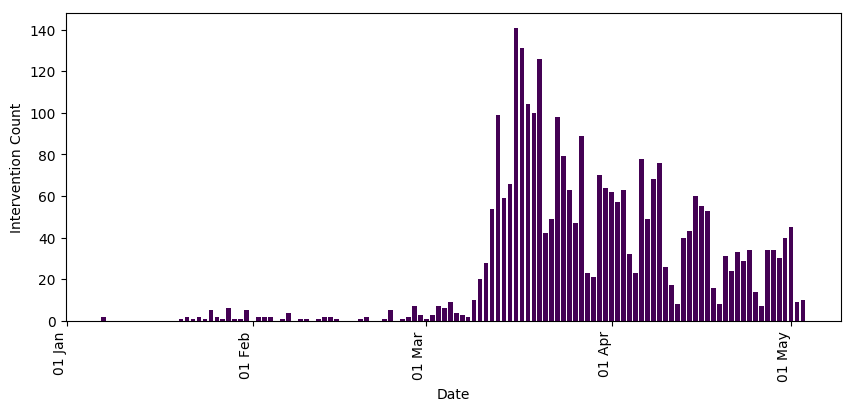

In [456]:
import matplotlib.dates as mdates
import matplotlib as mpl

fig, ax = plt.subplots(figsize=(10,4))

xticks = pd.date_range(start='12-01-2019', end='03-31-2020', freq='M')
#subset = full_df[full_df['start_date'] < pd.to_datetime('04-01-2020')]
ts = full_df.groupby(by=['start_date'])['intervention_category'].count()

cmap = mpl.cm.get_cmap('viridis')
plt.bar(ts.index, ts.values, color=cmap(0))

plt.xlabel('Date')
plt.ylabel('Intervention Count')
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
month_format = mdates.DateFormatter('%d %b')
plt.gca().xaxis.set_major_formatter(month_format)
plt.xticks(rotation=90, ha='right')

print(xticks)

DatetimeIndex(['2019-12-31', '2020-01-31', '2020-02-29', '2020-03-31',
               '2020-04-30'],
              dtype='datetime64[ns]', freq='M')


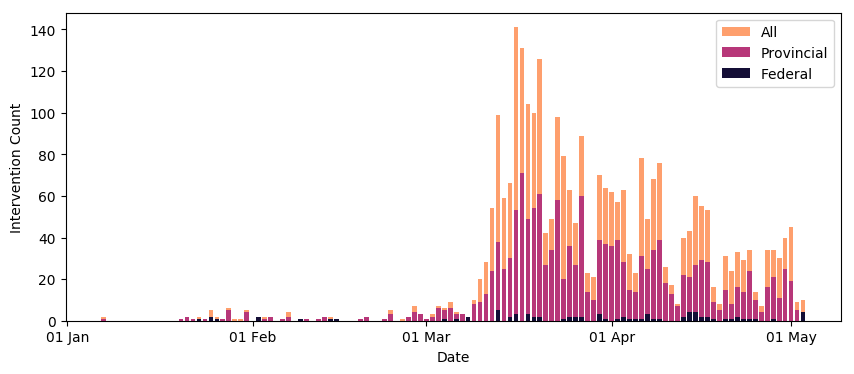

In [457]:
import matplotlib.dates as mdates
import matplotlib as mpl

fig, ax = plt.subplots(figsize=(10, 4))

xticks = pd.date_range(start='12-01-2019', end='05-17-2020', freq='M')
#subset = full_df[full_df['start_date'] < pd.to_datetime('04-01-2020')]


cmap = mpl.cm.get_cmap('magma')


ts = full_df.groupby(by=['start_date'])['intervention_category'].count()
plt.bar(ts.index, ts.values, color=cmap(0.8), label='All')

ts = provinces_df.groupby(by=['start_date'])['intervention_category'].count()
plt.bar(ts.index, ts.values, color=cmap(0.5), label='Provincial')

ts = federal_df.groupby(by=['start_date'])['intervention_category'].count()
plt.bar(ts.index, ts.values, color=cmap(0.1), label='Federal')



plt.xlabel('Date')
plt.ylabel('Intervention Count')
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
month_format = mdates.DateFormatter('%d %b')
plt.gca().xaxis.set_major_formatter(month_format)
print(xticks)
plt.legend()

#ts = full_df.subtract(provinces_df).groupby(by=['start_date'])['intervention_category'].count()
#cmap = mpl.cm.get_cmap('viridis')
#plt.bar(ts.index, ts.values, color=cmap(.5), alpha=0.4)
plt.savefig('doc/img/fig2.png', dpi=300)

# Geographical Distribution of Interventions

In [458]:
names = full_df['region']

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 <a list of 13 Text xticklabel objects>)

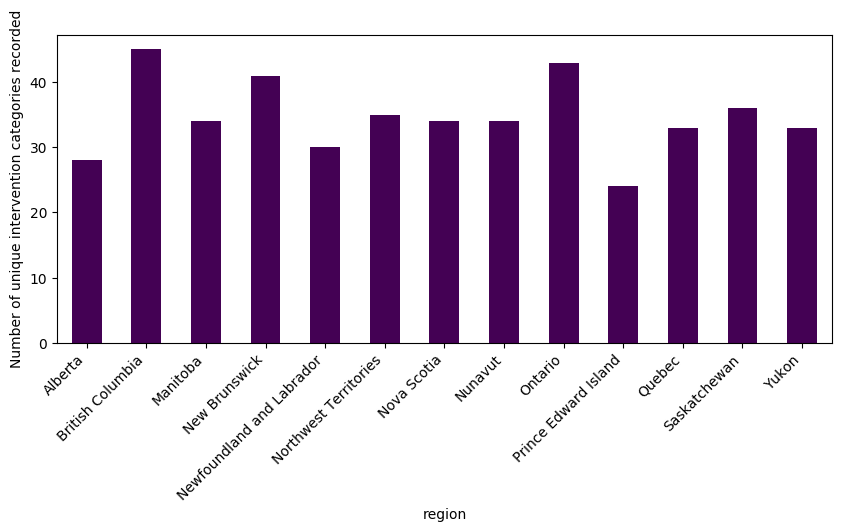

In [459]:
import matplotlib.ticker as ticker
provinces_df.dropna(subset=['region']).groupby(by=['region'])['intervention_category'].nunique().plot.bar(figsize=(10,4), cmap='viridis')
plt.ylabel('Number of unique intervention categories recorded')

#@ticker.FuncFormatter
#def major_formatter(x, pos):
#    return str(x).replace('(', '').replace('(', '')
#plt.gca().xaxis.set_major_formatter(major_formatter)
plt.xticks(rotation=45, ha='right')


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20]), <a list of 21 Text xticklabel objects>)

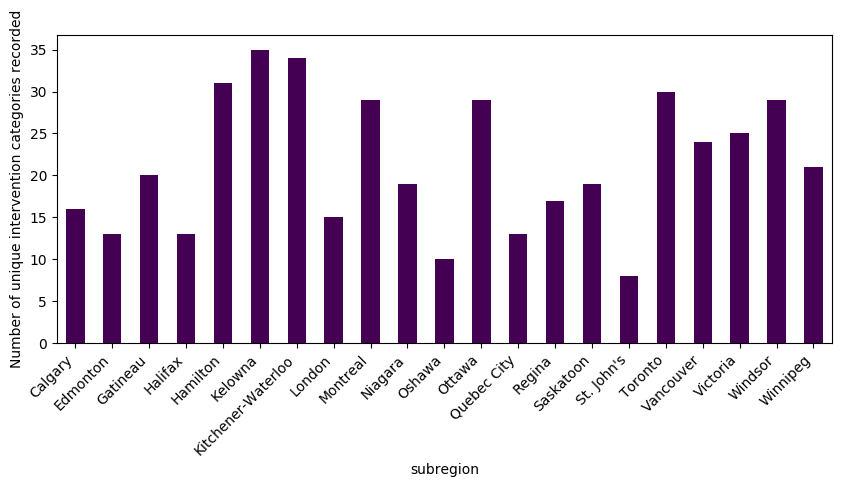

In [460]:
import matplotlib.ticker as ticker
subregions = full_df.dropna(subset=['subregion']).groupby(by=['subregion'])['intervention_category'].nunique()

subregions.plot.bar(figsize=(10,4), cmap='viridis')
plt.ylabel('Number of unique intervention categories recorded')

#@ticker.FuncFormatter
#def major_formatter(x, pos):
#    return str(x).replace('(', '').replace('(', '')
#plt.gca().xaxis.set_major_formatter(major_formatter)
plt.xticks(rotation=45, ha='right')


Text(0.5,0,'Number of unique Oxford interventions recorded')

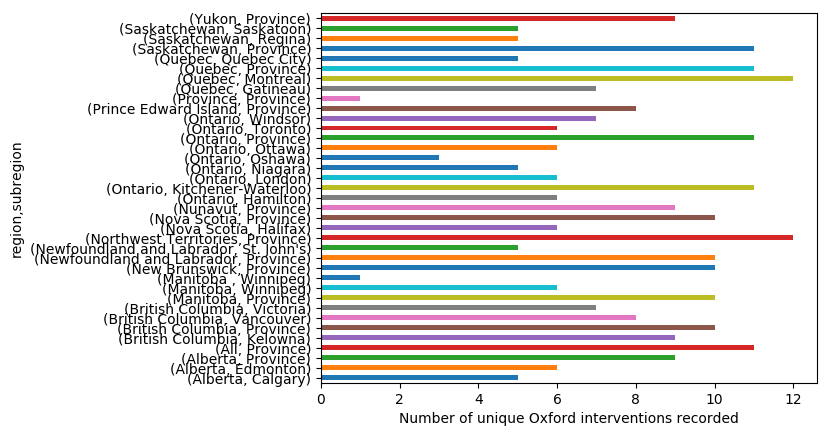

In [461]:
full_df.fillna('Province').groupby(by=['region', 'subregion'])['oxford_government_response_category'].nunique().plot.barh()
plt.xlabel('Number of unique Oxford interventions recorded')


Text(0,0.5,'Unique Intervention Categories Recorded')

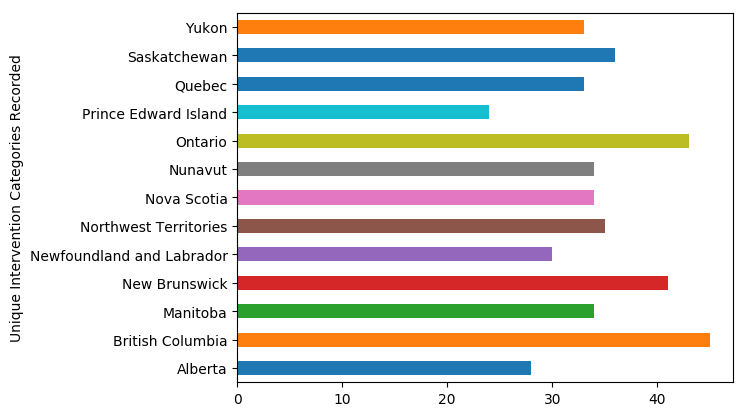

In [462]:
provinces_df.groupby(by='region')['intervention_category'].nunique().plot.barh()
plt.ylabel('Unique Intervention Categories Recorded')

Text(0.5,0,'Number of unique interventions recorded')

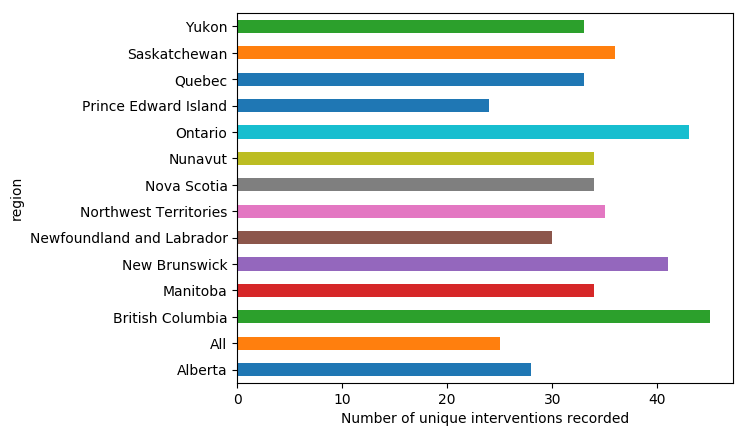

In [463]:
full_df[full_df['subregion'].isna()].groupby(by=['region'])['intervention_category'].nunique().plot.barh()
plt.xlabel('Number of unique interventions recorded')


Text(0.5,0,'Number of unique Oxford response measures recorded')

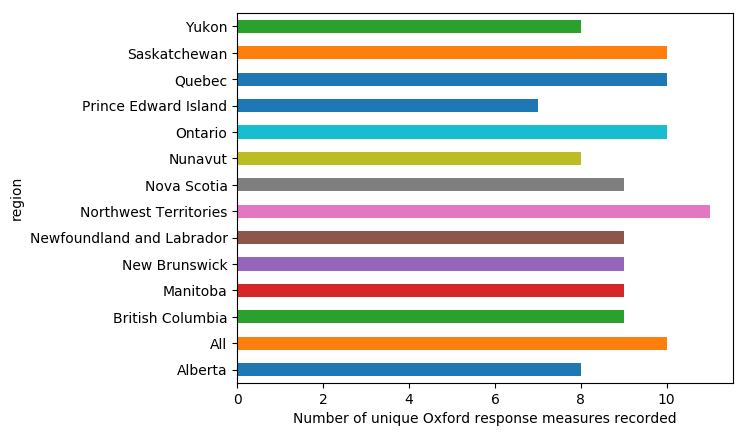

In [464]:
full_df[full_df['subregion'].isna()].groupby(by=['region'])['oxford_government_response_category'].nunique().plot.barh()
plt.xlabel('Number of unique Oxford response measures recorded')


Text(0.5,0,'Oxford Fiscal Measure (CAD) recorded')

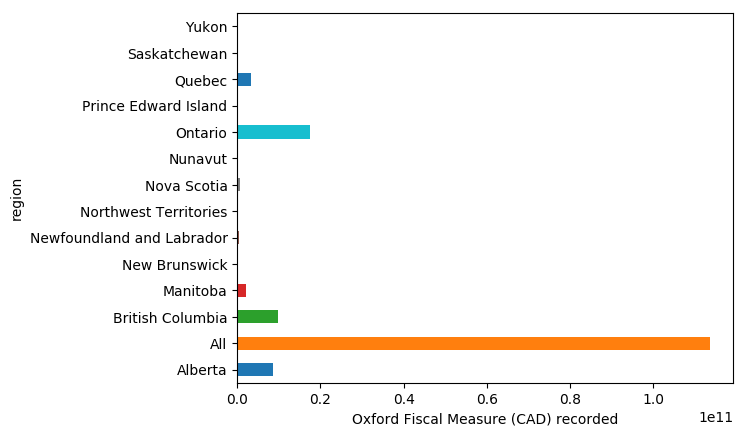

In [465]:
full_df[full_df['subregion'].isna()].groupby(by=['region'])['oxford_fiscal_measure_cad'].sum().plot.barh()
plt.xlabel('Oxford Fiscal Measure (CAD) recorded')


In [466]:
full_df[full_df['subregion'].isna()].groupby(by=['region'])['oxford_fiscal_measure_cad'].sum()

region
Alberta                      8.628300e+09
All                          1.135271e+11
British Columbia             9.875500e+09
Manitoba                     2.148925e+09
New Brunswick                1.845016e+08
Newfoundland and Labrador    3.205000e+08
Northwest Territories        1.645790e+08
Nova Scotia                  6.365100e+08
Nunavut                      5.292000e+07
Ontario                      1.737640e+10
Prince Edward Island         5.106000e+07
Quebec                       3.396900e+09
Saskatchewan                 1.576500e+08
Yukon                        2.170000e+07
Name: oxford_fiscal_measure_cad, dtype: float64

Text(0,0.5,'$ / person')

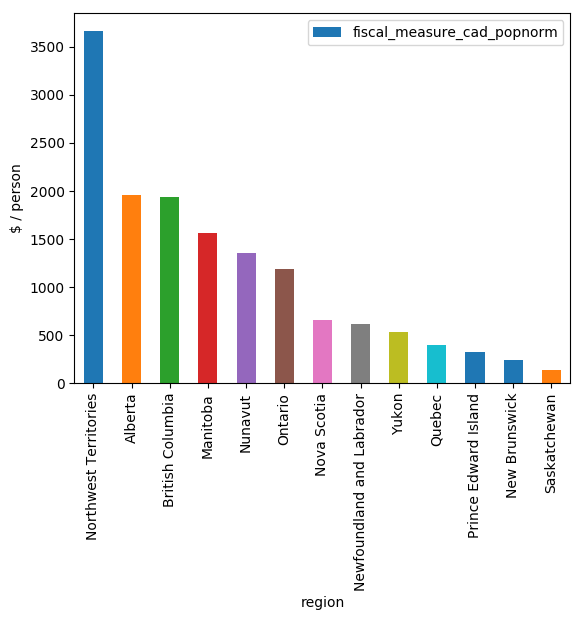

In [467]:
df = pd.DataFrame(provinces_df.groupby(by='region')['oxford_fiscal_measure_cad'].sum())
df['region'] = df.index
df = df.merge(population_df, on='region', how='left')
df['fiscal_measure_cad_popnorm'] = df['oxford_fiscal_measure_cad'] /  df['population_q1_2020']
df = df.sort_values(by='fiscal_measure_cad_popnorm', ascending=False)
df.plot.bar(x='region', y='fiscal_measure_cad_popnorm')
plt.ylabel("$ / person")

Text(0,0.5,'fiscal measures (CAD)')

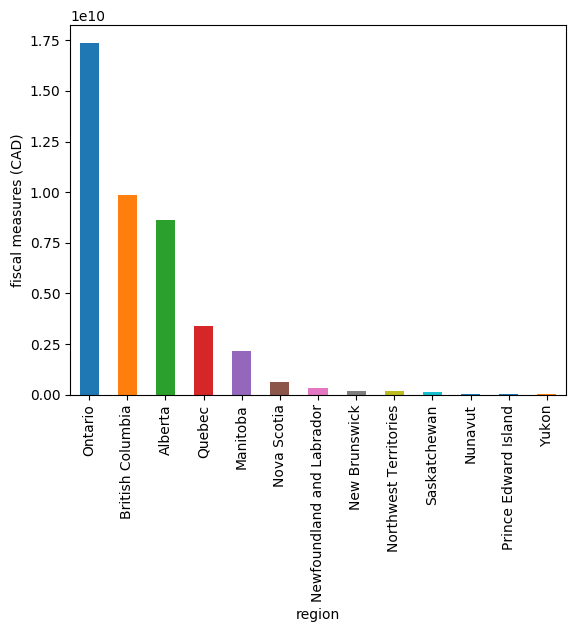

In [468]:
provinces_df.groupby(by='region')['oxford_fiscal_measure_cad'].sum().sort_values(ascending=False).plot.bar()
plt.ylabel('fiscal measures (CAD)')

# Comparing Provincial and Municipal Interventions of the Same Type

ValueError: NaTType does not support toordinal

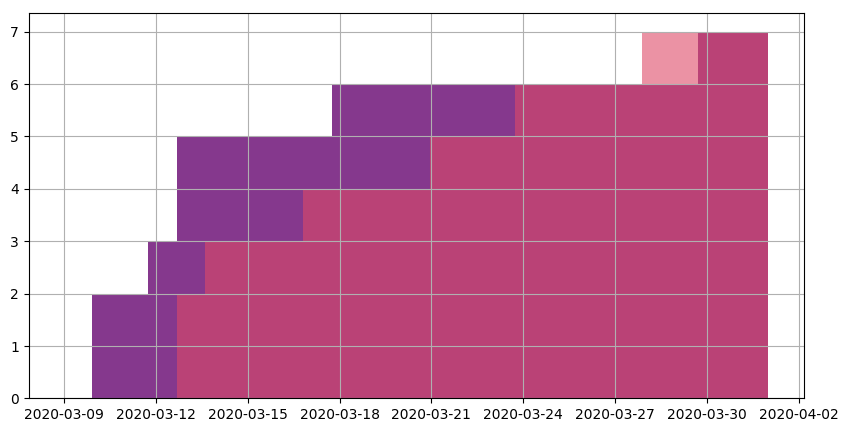

In [469]:
from matplotlib.dates import MO
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(10, 5)

ont_df = full_df[full_df['region'] == 'Ontario']

cmap = mpl.cm.get_cmap('magma')

soc = ont_df[ont_df['intervention_category'] == 'Social Distancing Announcement']
#rec = ont_df[ont_df['intervention_category'] == 'Recreational / Entertainment Facility Closure']
pem = ont_df[ont_df['intervention_category'] == 'Public event/ meeting cancellation or postponement']
#park = ont_df[ont_df['intervention_category'] == 'Public park closure']

start = datetime(2020, 3, 9)
end = datetime(2020, 4, 1) 
drange=(start, end)

pem.groupby('subregion').min()['start_date'].hist(bins=50, range=drange, color=cmap(0.35),  alpha=0.9, cumulative=True, label='Public event cancellation')
#rec.groupby('subregion').min()['start_date'].hist(bins=30, color=cmap(0.8), alpha=0.5, cumulative=True, label='Recreational / Entertainment Facility Closure')
soc.groupby('subregion').min()['start_date'].hist(bins=50, range=drange, color=cmap(0.6), alpha=0.6, cumulative=True, label='Social distancing announcements')
#park.groupby('subregion').min()['start_date'].hist(color='red', alpha=0.5, label='Public park closure')

a = soc[soc['subregion'].isna()]
soc_ont = a[a['intervention_category'] == 'Social Distancing Announcement']
soc_ont_date = soc_ont['start_date'].min()

#a = rec[rec['subregion'].isna()]
rec_ont = a[a['intervention_category'] == 'Recreational / Entertainment Facility Closure']
rec_ont_date = rec_ont['start_date'].min()

plt.axvline(x=rec_ont_date, label='First provincial public event cancellation', color=cmap(0.25), linewidth=2)
plt.axvline(x=soc_ont_date, label='First provincial social distancing announcement', color=cmap(0.65), linewidth=2)

plt.xticks(rotation=45, ha='right')
plt.legend(loc="lower right")
plt.title('Municipality interventions over time in Ontario compared with Provincial interventions')

plt.xlabel('Date')
plt.ylabel('Municipalities with intervention')
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=(MO)))
month_format = mdates.DateFormatter('%d %b')
plt.gca().xaxis.set_major_formatter(month_format)


## Heatmap of cumulative municipal top intervention categories

In [ ]:
# Thanks to matplotlib documentation for this

def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar

def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=["black", "white"],
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A list or array of two color specifications.  The first is used for
        values below a threshold, the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

In [ ]:
top_interventions = full_df.groupby(by='subregion')['intervention_category'].value_counts() \
    .groupby(by='intervention_category') \
    .count() \
    .sort_values(ascending=False)[:10] \
    
top_interventions

In [ ]:
cma_population= pd.DataFrame([['Toronto', 5429524],
                ["Montreal", 3519595],
                ["Vancouver", 2264823],
                ["Calgary", 1237656],
                ["Edmonton", 1062643],
                ["Ottawa", 989657],
                ["Gatineau", 989657],
                ["Winnipeg", 711925],
                ["Quebec City", 705103],
                ["Hamilton", 693645],
                ["Kitchener-Waterloo", 535154],
                ["London", 383437],
                ["Victoria", 335696],
                ["Halifax", 316701],
                ["Oshawa", 308875],
                ["Windsor", 287069],
                ["Saskatoon", 245181],
                ["Niagara", 229246],
                ["Regina", 214631],
                ["St. John's", 178427],
                ["Kelowna", 151957]], columns=['subregion', 'population'])
# Population numbers from Canadian Census 2016

In [ ]:
filtered_df = full_df[full_df['intervention_category'].isin(top_interventions.index.values)]
#filtered_df = filtered_df.groupby(by=['subregion', 'start_date']).nunique()['intervention_category']
filtered_df = filtered_df.merge(cma_population, on='subregion')
filtered_df = filtered_df.sort_values(by='population', ascending=False)
soc_count = filtered_df.groupby(by=['subregion', 'intervention_category'], sort=False).min()['start_date']
#soc_count = soc_count.merge(cma_population, on='subregion')

xticks = pd.date_range(start='03-08-2020', end='04-19-2020', freq='W')


col = ['subregion', *xticks.date]
cma_df = pd.DataFrame()

for subregion in soc_count.index.get_level_values(0).unique():
    dates = soc_count.loc[[subregion]].reset_index()
    empty_row = [subregion]
    for week_end in xticks.values:
        count = dates[dates['start_date'] < week_end]['intervention_category'].count()
        empty_row.append(count)
    cma_df = cma_df.append([empty_row])
    
cma_df.columns = col
cma_df = cma_df.set_index('subregion')

In [ ]:
#fig, (a0, a1) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [5, 1]}, figsize=(10,6))
fig, ax = plt.subplots(figsize=(10,8))

nice_date = [x.strftime('%B %d') for x in cma_df.columns.values]

im, cbar = heatmap(cma_df.values, cma_df.index.values, nice_date, ax=ax,
                   cmap="magma_r", cbarlabel="# of distinct intervention categories")
texts = annotate_heatmap(im, valfmt="{x:.0f}")

fig.tight_layout()
plt.savefig('doc/img/fig5.png', dpi=300)

# Mobility comparison

In [ ]:
ox = full_df['oxford_government_response_category'].unique()

In [ ]:
ox[2]

In [ ]:
gb = provinces_df.groupby(by='region')
for gb_name, g in gb:
    for intervention in ox:
        rows = g[g['oxford_government_response_category'] == intervention]
        if ox[2] in rows['oxford_government_response_category']: # public events
            print(rows['oxford_closure_code'])

In [ ]:
g['oxford_government_response_category'].mode()